<a href="https://colab.research.google.com/github/aiaaee/Iris/blob/main/Iris.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
from torch.utils.data import Dataset , DataLoader
import torch
from torchvision import transforms
import torch.nn.functional as F
from tqdm import tqdm
import torch.optim  as optim

In [ ]:
iris = datasets.load_iris()


X = iris.data
y = iris.target

In [ ]:
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size=0.2 , random_state=42 , shuffle=True)

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
class irisDataset(Dataset):
  def __init__(self , data , target , dataTransform=None , targetTransform=None):
    super().__init__()
    self.data = data
    self.target = target
    self.dataTransform = dataTransform
    self.targetTransform = targetTransform
  def __len__(self) :
    return len(self.data)
  def __getitem__(self , index):
    x = self.data[index]
    y = self.target[index]
    if(self.dataTransform) :
      x = self.dataTransform(x)
    if(self.targetTransform):
      y = self.dataTransform(y)

    return x , y

In [ ]:
train_dataset = irisDataset(X_train , y_train , dataTransform=transforms.Lambda(lambda x: torch.tensor(x, dtype=torch.float32)) , targetTransform=transforms.Lambda(lambda x: torch.tensor(x, dtype=torch.float32).unsqueeze(0)))
test_dataset = irisDataset(X_test , y_test , dataTransform=transforms.Lambda(lambda x: torch.tensor(x, dtype=torch.float32)) , targetTransform=transforms.Lambda(lambda x: torch.tensor(x, dtype=torch.float32).unsqueeze(0)))

train_loader = DataLoader(train_dataset , shuffle=True , batch_size=32)
test_loader = DataLoader(test_dataset , shuffle=False , batch_size=32)

In [ ]:
train_dataset

In [ ]:
for i , y in train_loader:
  print(i.size())
  break

torch.Size([32, 4])


In [ ]:
class NN(nn.Module):
  def __init__(self , input_layer=int , output_layer=int , *args , **kwargs):
    super().__init__(*args , **kwargs)
    self.flatten = nn.Flatten()
    self.l1 = nn.Linear(input_layer , 300)
    self.l2 = nn.Linear(300, 600)
    self.l3 = nn.Linear(600 , output_layer)

  def forward(self , x ):
    x = self.flatten(x)
    x = F.relu(self.l1(x))
    x = F.relu(self.l2(x))
    x = F.relu(self.l3(x))

    return x

In [ ]:
# x = torch.rand(32 , 4)

model = NN(4 , 1)
# model(x).size()

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()


In [ ]:
train_history = []
validation_history = []
num_epochs = 30
for epoch in range(num_epochs):

    model.train()
    losses = []

    with tqdm(train_loader, leave=False) as bar:
        bar.set_description(f"[Epoch: {epoch + 1}/{num_epochs}]")

        for batch_idx, (data, target) in enumerate(bar):

            data = data
            target = target

            output = model(data)

            loss = criterion(output, target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses.append(loss.item())
            bar.set_postfix(avg_epoch_loss=f"{sum(losses)/len(losses):.4f}")
    train_history.append(sum(losses)/len(losses))

    model.eval()
    running_testloss = 0.0

    with torch.no_grad():
        for i, (test_data, test_label) in enumerate(test_loader):
            test_output = model(test_data)
            vloss = criterion(test_output, test_label)
            running_testloss += vloss.item()
        avg_vloss = running_testloss / (i + 1)
        validation_history.append(avg_vloss)
        if epoch % 10 == 9:
            print(f'Epoch [{epoch + 1}/{num_epochs}]: loss train: {sum(losses)/len(losses):.3f}, validation: {avg_vloss:.3f}')


[Epoch: 1/30]:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
[Epoch: 1/30]:   0%|          | 0/4 [00:00<?, ?it/s, avg_epoch_loss=1.0173]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). Th

Epoch [10/30]: loss train: 0.683, validation: 0.714


Epoch [20/30]: loss train: 0.657, validation: 0.704


Epoch [30/30]: loss train: 0.671, validation: 0.723


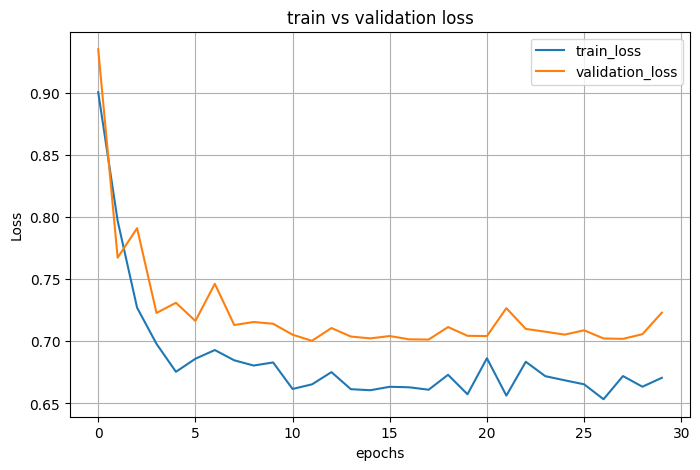

In [ ]:



fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(train_history, label="train_loss")
ax.plot(validation_history, label="validation_loss")
ax.set_title("train vs validation loss")
ax.set_ylabel('Loss')
ax.set_xlabel('epochs')
ax.grid()
ax.legend(loc='upper right')

torch.Size([24])